In [45]:
conda install -c conda-forge imbalanced-learn

Retrieving notices: ...working... done
Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.



In [23]:
#importing libraries and add-ons
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Flatten, Dense
import keras
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout,Activation
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from tensorflow.keras.metrics import AUC

In [3]:
base_dir = "D:/800 Project/dataset/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


#Splitting data into test, train, and validation  

In [4]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 5900 images belonging to 4 classes.


In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:
print(train_data.shape, train_labels.shape)

(5900, 128, 128, 3) (5900, 4)


In [8]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10800, 128, 128, 3) (10800, 4)


In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
test_data.shape

(2160, 128, 128, 3)

#Implementing Convolutional Neural Network (CNN)

In [11]:
from tensorflow import keras
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [128,128,3], padding='same'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])



In [49]:
from keras.utils.vis_utils import plot_model
plot_model(model,  
           show_shapes=True, show_layer_names=True)
plt.savefig("Model.png")

<Figure size 640x480 with 0 Axes>

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks = [early_stopping, reduce_lr]

In [51]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc')]

    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS,)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 separable_conv2d_6 (Separab  (None, 32, 32, 64)       2400      
 leConv2D)                                                       
                                                      

In [54]:
history = model.fit(train_data, train_labels,  
                    validation_data=(val_data, val_labels),   
                    epochs=50,verbose=0)

In [56]:
cnn_df = pd.DataFrame(history.history)

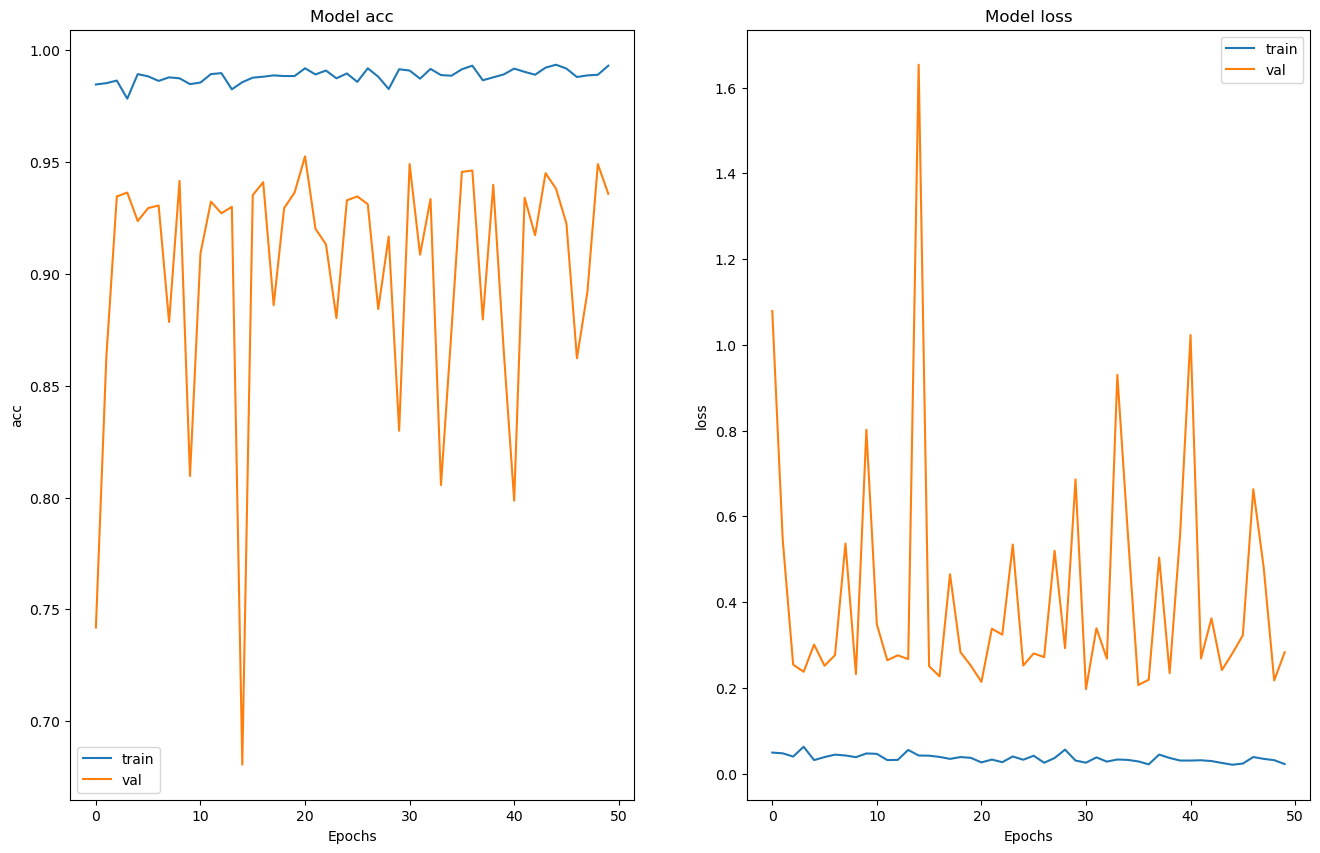

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (16, 10))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [60]:
test_scores = model.evaluate(test_data, test_labels)
print(test_scores)

68/68 [==============================] - 17s 180ms/step - loss: 0.3250 - acc: 0.9287
[0.3249668478965759, 0.9287037253379822]


In [61]:
pred_labels = model.predict(test_data)

68/68 [==============================] - 5s 61ms/step


In [62]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.91      0.99      0.95       527
VeryMildDemented       0.99      1.00      1.00       541
    MildDemented       0.92      0.87      0.90       524
ModerateDemented       0.90      0.86      0.88       568

       micro avg       0.93      0.93      0.93      2160
       macro avg       0.93      0.93      0.93      2160
    weighted avg       0.93      0.93      0.93      2160
     samples avg       0.93      0.93      0.93      2160



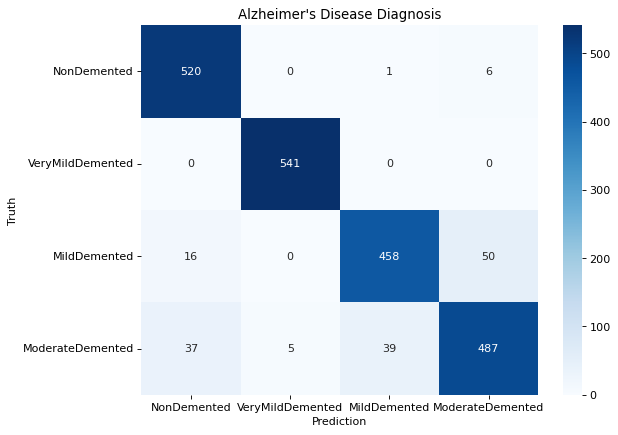

In [63]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

#Implementing VGG19

In [1]:
import os
for dirname, _, filenames in os.walk('D:/800 Project/dataset/Alzheimer_s Dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (19).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (20).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (21).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (22).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (23).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (24).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (25).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (26).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (27).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26 (28).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\26.jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\27 (10).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDemented\27 (11).jpg
D:/800 Project/dataset/Alzheimer_s Dataset/test\MildDeme

In [3]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 
import scipy

In [4]:
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [26]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='D:/800 Project/dataset/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='D:/800 Project/dataset/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')
image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='D:/800 Project/dataset/Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                 target_size=(176,208), 
                                                 class_mode=None)

Found 3698 images belonging to 4 classes.
Found 923 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [6]:
vgg = VGG19(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [18]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
modelvgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')  
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [19]:
      hist = modelvgg.fit(train_dataset, epochs=30,  validation_data=validation_dataset, callbacks=callback)

Epoch 1/30
463/463 [==============================] - 773s 2s/step - loss: 0.0407 - accuracy: 0.9919 - val_loss: 1.0293 - val_accuracy: 0.7053
Epoch 2/30
463/463 [==============================] - 846s 2s/step - loss: 0.1019 - accuracy: 0.9749 - val_loss: 0.9438 - val_accuracy: 0.7129
Epoch 3/30
463/463 [==============================] - 835s 2s/step - loss: 0.0198 - accuracy: 0.9976 - val_loss: 0.9032 - val_accuracy: 0.7161
Epoch 4/30
463/463 [==============================] - 847s 2s/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.8535 - val_accuracy: 0.7237
Epoch 5/30
463/463 [==============================] - 843s 2s/step - loss: 0.0246 - accuracy: 0.9943 - val_loss: 1.2091 - val_accuracy: 0.6674
Epoch 6/30
463/463 [==============================] - 835s 2s/step - loss: 0.0542 - accuracy: 0.9849 - val_loss: 0.9100 - val_accuracy: 0.7183
Epoch 7/30
463/463 [==============================] - 38468s 83s/step - loss: 0.0216 - accuracy: 0.9954 - val_loss: 0.8937 - val_accuracy: 0.7

In [20]:
loss, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

116/116 [==============================] - 125s 1s/step - loss: 0.8408 - accuracy: 0.7400
Loss:  0.8407791256904602
Accuracy:  0.7399783134460449


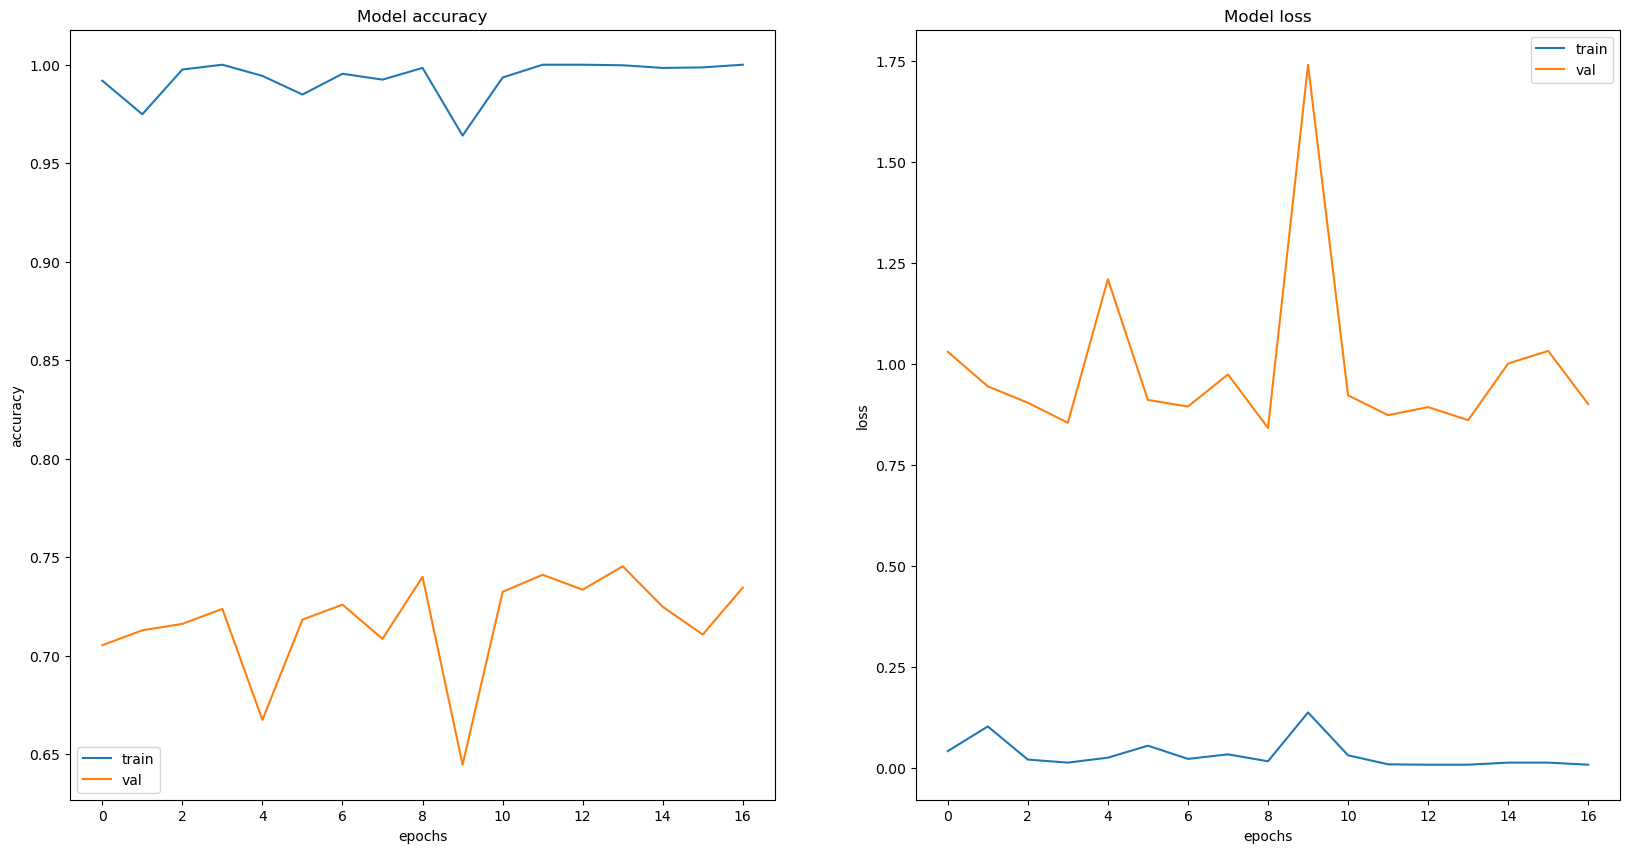

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
test_scores = modelvgg.evaluate(submission)

40/40 [==============================] - 2s 34ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
